In [2]:
import numpy as np
import arepo
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter
from tqdm import tqdm
import matplotlib as mpl
from scipy.stats import binned_statistic_2d
from numba import njit
import h5py as h5

import astropy.units as u

In [3]:
basepath = '/n/holylfs05/LABS/hernquist_lab/Users/abeane/GSEgas/'

In [151]:
MC = {}
MC120 = {}
for num in tqdm(np.arange(0, 460, 10)):
    MC[num] = h5.File(basepath + 
                      'anlys/MC/MW4_MHG0.15_GSE6_kick-lvl4/MC_Prop_'+str(num).zfill(3)+'.h5', 
                      mode='r')
    
    MC120[num] = h5.File(basepath + 
                         'anlys/MC/MW4_MHG0.15_GSE6_kick120-lvl4/MC_Prop_'+str(num).zfill(3)+'.h5', 
                         mode='r')    

100%|██████████| 46/46 [00:00<00:00, 211.59it/s]


In [152]:
COM = np.load(basepath + 'anlys/COM/COM_MW4_MHG0.15_GSE6_kick-lvl4.npy', allow_pickle=True).item()
COM120 = np.load(basepath + 'anlys/COM/COM_MW4_MHG0.15_GSE6_kick120-lvl4.npy', allow_pickle=True).item()

In [153]:
def get_Mstrip(MC, COM):

    MstripGSE = []
    MstripCGM = []
    Time = []

    rcut = 25

    for snap in tqdm(MC.keys()):
        GSE_COM = COM['GSE_COM'][snap]
        MW_COM = COM['MW_COM'][snap]
    
        pos = MC[snap]['PartType5/Coordinates'][:]
        memb = MC[snap]['PartType5/Membership'][:]
        ptype = MC[snap]['PartType5/PartType'][:]
        T = MC[snap]['PartType5/Temperature'][:]
    
        rGSE = np.linalg.norm(pos - GSE_COM, axis=1)
        rMW = np.linalg.norm(pos - MW_COM, axis=1)
    
        mass = MC[snap]['Header'].attrs['TracerMass']
    
        Time.append(MC[snap]['Header'].attrs['Time'])
    
        stripped = np.logical_and(rMW > rcut, rGSE > rcut)
        is_gas = ptype == 0
        is_GSE = memb == 2
        is_CGM = memb == 1
        key = np.logical_and(stripped, is_gas)
        keyGSE = np.logical_and(key, is_GSE)
        keyCGM = np.logical_and(key, is_CGM)
        keyCGM = np.logical_and(keyCGM, T < 3E4)
    
        MstripGSE.append(mass * len(np.where(keyGSE)[0]))
        MstripCGM.append(mass * len(np.where(keyCGM)[0]))
    
    Time = np.array(Time)
    MstripGSE = np.array(MstripGSE)
    MstripCGM = np.array(MstripCGM)
    
    return Time, MstripGSE, MstripCGM

100%|██████████| 46/46 [00:06<00:00,  6.79it/s]


(0.0, 0.07619816714773293)

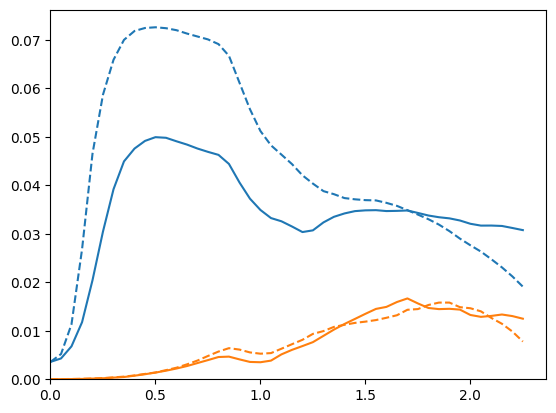

In [155]:
Time, MstripGSE, MstripCGM = get_Mstrip(MC, COM)
l0 = plt.plot(Time, MstripGSE)
l1 = plt.plot(Time, MstripCGM)

Time, MstripGSE, MstripCGM = get_Mstrip(MC120, COM120)
plt.plot(Time, MstripGSE, c=l0[0].get_color(), ls='dashed')
plt.plot(Time, MstripCGM, c=l1[0].get_color(), ls='dashed')

plt.xlim(0, None)
plt.ylim(0, None)

# check similar mass galaxies in TNG

In [4]:
import illustris_python as il
TNGbase = '/n/holylfs05/LABS/hernquist_lab/IllustrisTNG/Runs/L35n2160TNG/output/'

In [5]:
def get_n_T(InternalEnergy, ElectronAbundance, Density, header):
    UnitLength = header.parameters.UnitLength_in_cm
    UnitMass = header.parameters.UnitMass_in_g
    UnitVelocity = header.parameters.UnitVelocity_in_cm_per_s

    UnitTime = UnitLength / UnitVelocity
    UnitEnergy = UnitMass * UnitVelocity**2

    HYDROGEN_MASSFRAC = 0.76
    GAMMA = 5./3.
    PROTONMASS = 1.67262178e-24
    BOLTZMANN = 1.38065e-16

#     InternalEnergy = sn.part0.InternalEnergy.value
#     ElectronAbundance = sn.part0.ElectronAbundance
#     Density = sn.part0.Density.value
    
    mu = 4 * PROTONMASS / (1 + 3 * HYDROGEN_MASSFRAC + 4 * HYDROGEN_MASSFRAC * ElectronAbundance)
    T = (GAMMA - 1.) * (InternalEnergy / BOLTZMANN) * (UnitEnergy / UnitMass) * mu

    n = Density / mu
    n *= UnitMass/UnitLength**3
    
    return n, T

In [6]:
snapnum = 33

header = arepo.Snapshot(TNGbase, snapnum, onlyHeader=True)

In [7]:
subhalo = il.groupcat.loadSubhalos(TNGbase, snapnum, fields=['SubhaloMassInRadType', 
                                                             'SubhaloPos', 
                                                             'SubhaloGrNr',
                                                             'SubhaloMassInMaxRadType',
                                                             'SubhaloVmaxRad'])

fof = il.groupcat.loadHalos(TNGbase, snapnum, fields=['GroupFirstSub',
                                                      'GroupMass',
                                                      'Group_M_Mean200',
                                                      'Group_R_Mean200',
                                                      # 'Group_R_Mean500',
                                                     'Group_R_Crit200',
                                                     'Group_R_Crit500',
                                                     'GroupPos'])

In [10]:
stellar_mass = subhalo['SubhaloMassInRadType'][:,4]
gas_mass = subhalo['SubhaloMassInRadType'][:,0]

# within 10% of target stellar mass
Mtarget = 5E8 * header.HubbleParam / 1E10
Mlow = 0.9 * Mtarget
Mhigh = 1.1 * Mtarget

key = np.logical_and(stellar_mass > Mlow, stellar_mass < Mhigh)

# is a first sub
first_sub = fof['GroupFirstSub'][subhalo['SubhaloGrNr']]
is_first_sub = first_sub == np.arange(len(first_sub))

key = np.logical_and(key, is_first_sub)

# is within 10% of M200
M200 = fof['GroupMass'][subhalo['SubhaloGrNr']]

Mtarget = 2.16E11 * header.HubbleParam / 1E10
Mlow = 0.9 * Mtarget
Mhigh = 1.1 * Mtarget

key = np.logical_and(key, np.logical_and(M200 > Mlow, M200 < Mhigh))

print(len(np.where(key)[0]))

subID_list = np.where(key)[0]

print(subID_list)

7
[282079 289540 292111 301182 301744 304953 305500]


In [37]:
for subID in subID_list:
    fofID = subhalo['SubhaloGrNr'][subID]
    
    R200 = fof['Group_R_Mean200'][fofID]
    Rc200 = fof['Group_R_Crit200'][fofID]
    
    # print(R200, Rc200)
    grouppos = fof['GroupPos'][fofID]

    part0 = il.snapshot.loadHalo(TNGbase, snapnum, fofID, 0, fields=None)
    part1 = il.snapshot.loadHalo(TNGbase, snapnum, fofID, 1, fields=None)
    part4 = il.snapshot.loadHalo(TNGbase, snapnum, fofID, 4, fields=None)
    part5 = il.snapshot.loadHalo(TNGbase, snapnum, fofID, 5, fields=None)
    
    r0 = np.linalg.norm(part0['Coordinates'] - grouppos, axis=1)
    r1 = np.linalg.norm(part1['Coordinates'] - grouppos, axis=1)
    r4 = np.linalg.norm(part4['Coordinates'] - grouppos, axis=1)
    r5 = np.linalg.norm(part5['Coordinates'] - grouppos, axis=1)
    
    in200_0 = r0 < R200
    in200_1 = r1 < R200
    in200_4 = r4 < R200
    in200_5 = r5 < R200
    
    # print(len(np.where(in200_1)[0]))
    
    M0 = np.sum(part0['Masses'][in200_0])
    M1 = header.MassTable[1] * len(np.where(in200_1)[0])
    M4 = np.sum(part4['Masses'][in200_4])
    M5 = np.sum(part5['Masses'][in200_5])
    
    print('R200:', R200 * header.Time/header.HubbleParam)
    print('baryon fraction:', (M5+M4+M0)/(M1))
    

R200: 63.69482793685483
baryon fraction: 0.18040824086503504
R200: 51.36282764825989
baryon fraction: 0.17342524646108992
R200: 52.38990907105477
baryon fraction: 0.15584572661402296
R200: 62.21795686134041
baryon fraction: 0.16078467865718116
R200: 53.145343640553605
baryon fraction: 0.19074922995287247
R200: 62.07727871231904
baryon fraction: 0.1408852529641056
R200: 55.46567583197026
baryon fraction: 0.12068902920961042


In [9]:
snap_gas = {}
rgas = {}
Tgas = {}
Bpress = {}
Ptherm = {}
Zhalo = {}
for subID in tqdm(subID_list):
    fofID = subhalo['SubhaloGrNr'][subID]

    fields = ['Coordinates', 'Masses', 'Density', 'InternalEnergy', 'ElectronAbundance',
              'MagneticField', 'GFM_Metallicity']
    snap_gas[subID] = il.snapshot.loadSubhalo(TNGbase, snapnum, subID, 0, fields=fields)
    
    n, T = get_n_T(snap_gas[subID]['InternalEnergy'],
               snap_gas[subID]['ElectronAbundance'],
               snap_gas[subID]['Density'],
               header)

    pos = snap_gas[subID]['Coordinates'] - subhalo['SubhaloPos'][subID]

    pos *= header.Time / header.HubbleParam

    r = np.linalg.norm(pos, axis=1)
    
    rgas[subID] = r
    Tgas[subID] = T
    
    Bmag = np.linalg.norm(snap_gas[subID]['MagneticField'], axis=1)
    Bmag *= header.HubbleParam/(header.Time**2)
    Bpress[subID] = Bmag**2 / (2*header.Time)
    
    Ptherm[subID] = (5/3 - 1) * snap_gas[subID]['Density'] * (header.HubbleParam**2/header.Time**3) * snap_gas[subID]['InternalEnergy']
    
    in_halo = rgas[subID] > 20
    Zhalo[subID] = np.mean(snap_gas[subID]['GFM_Metallicity'][in_halo])

100%|██████████| 7/7 [00:00<00:00, 38.19it/s]


cold fraction 0.53173876
Z halo= -1.1669585187079234
cold fraction 0.53562003
Z halo= -1.233470989610449
cold fraction 0.5115681
Z halo= -1.2966405996795505
cold fraction 0.425
Z halo= -1.1380744955900621
cold fraction 0.5559845
Z halo= -1.2346993794466359
cold fraction 0.37963763
Z halo= -1.2793567561916819
cold fraction 0.3452381
Z halo= -1.356954022394364


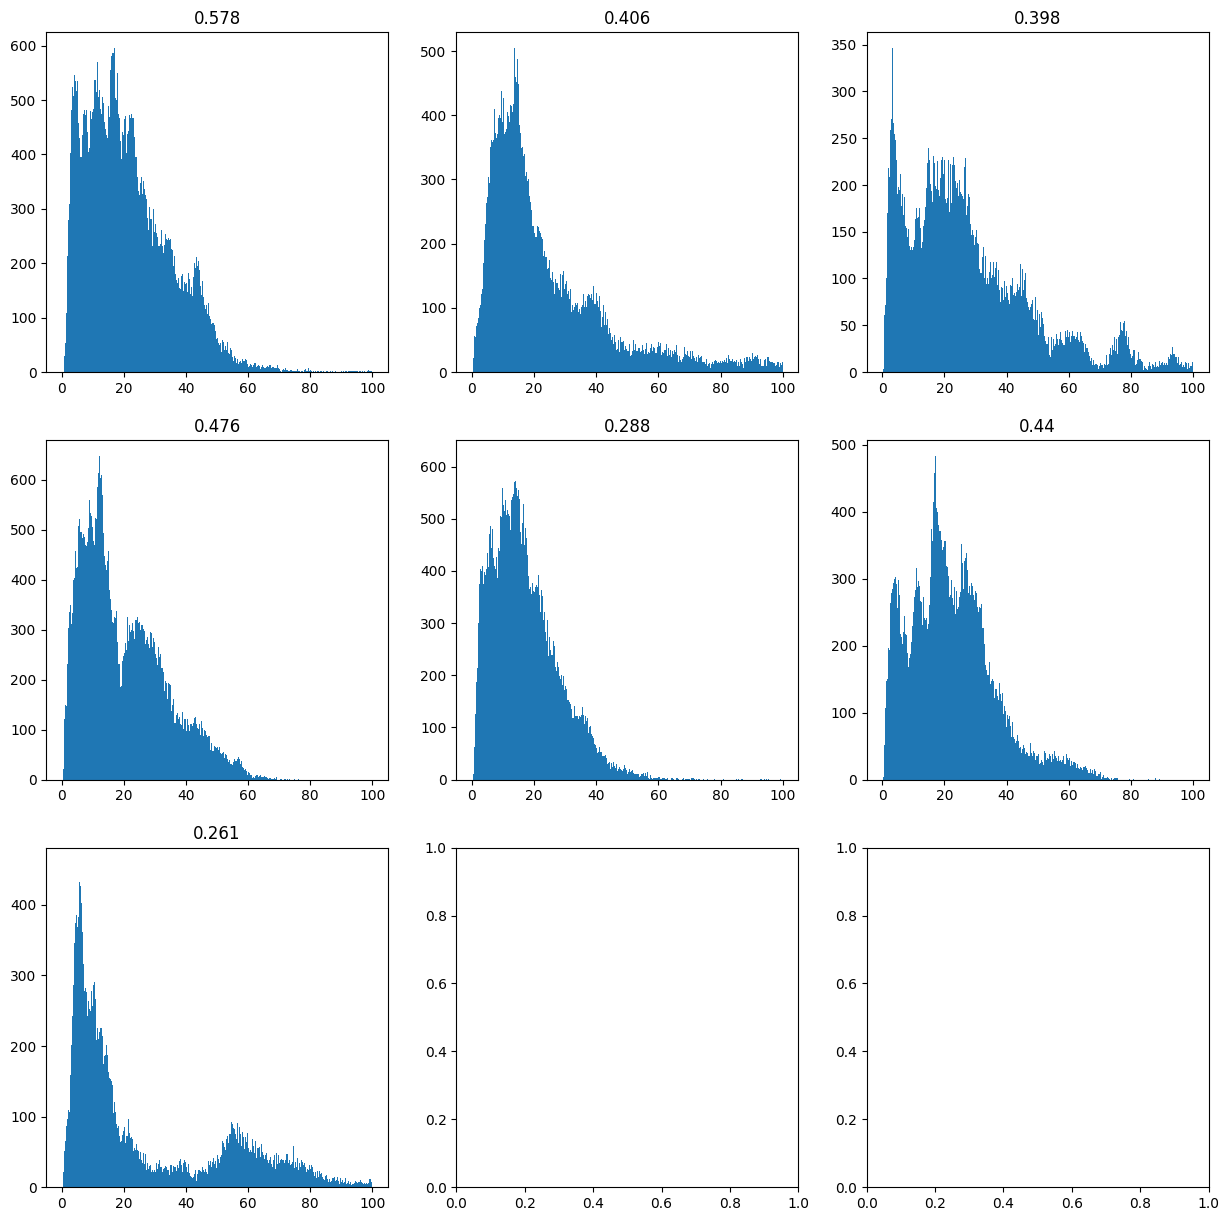

In [11]:
fig, ax = plt.subplots(3, 3, figsize=(15, 15))

for x,subID in zip(ax.ravel(), subID_list):
    r = rgas[subID]
    T = Tgas[subID]
    
    x.hist(r[T < 3E4], bins=np.linspace(0, 100, 1000));

    is_cold = T < 3E4
    is_out = r > 25
    is_coolio = np.logical_and(is_cold, is_out)
    is_warmio = np.logical_and(np.logical_not(is_cold), is_out)
    cold_mass = round(np.sum(snap_gas[subID]['Masses'][is_coolio]/header.HubbleParam), 3)
    warm_mass = round(np.sum(snap_gas[subID]['Masses'][is_warmio]/header.HubbleParam), 3)
    x.set_title(cold_mass)

    print('cold fraction', cold_mass/(cold_mass+warm_mass)) 
    print('Z halo=', np.log10(Zhalo[subID]/0.0127))

In [ ]:
### fig, ax = plt.subplots(3, 3, figsize=(15, 15))

for x,subID in zip(ax.ravel(), subID_list):
    PB = Bpress[subID]
    PT = Ptherm[subID]
    
    x.hist(np.log10(PT/PB), bins=np.linspace(-3, 3, 1000));

    # is_cold = T < 3E4
    # is_out = r > 25
    # is_coolio = np.logical_and(is_cold, is_out)
    # x.set_title(round(np.sum(snap_gas[subID]['Masses'][is_coolio]/header.HubbleParam), 3))


In [11]:
stellar_mass = subhalo['SubhaloMassInRadType'][:,4]
gas_mass = subhalo['SubhaloMassInRadType'][:,0]

# within 10% of target stellar mass
Mtarget = (6E9+8E9) * header.HubbleParam / 1E10
Mlow = 0.9 * Mtarget
Mhigh = 1.1 * Mtarget

key = np.logical_and(stellar_mass > Mlow, stellar_mass < Mhigh)

# is a first sub
first_sub = fof['GroupFirstSub'][subhalo['SubhaloGrNr']]
is_first_sub = first_sub == np.arange(len(first_sub))

key = np.logical_and(key, is_first_sub)

# is within 10% of M200
M200 = fof['GroupMass'][subhalo['SubhaloGrNr']]

Mtarget = 4.99E11 * header.HubbleParam / 1E10
Mlow = 0.9 * Mtarget
Mhigh = 1.1 * Mtarget

key = np.logical_and(key, np.logical_and(M200 > Mlow, M200 < Mhigh))

print(len(np.where(key)[0]))

subID_list = np.where(key)[0]

7


In [12]:
print(subID_list)

[194075 197277 198584 201029 202434 204481 204928]


In [35]:
snap_gas = {}
rgas = {}
Tgas = {}
mgas = {}
sfrgas = {}
posgas = {}
velgas = {}
Bpress = {}
Ptherm = {}
Zhalo = {}
Zdisk = {}
for subID in tqdm(subID_list):
    fofID = subhalo['SubhaloGrNr'][subID]

    fields = ['Coordinates', 'Masses', 'Density', 'InternalEnergy', 'ElectronAbundance',
              'MagneticField', 'GFM_Metallicity', 'Velocities', 'StarFormationRate']
    snap_gas[subID] = il.snapshot.loadSubhalo(TNGbase, snapnum, subID, 0, fields=fields)
    
    snap_star = il.snapshot.loadSubhalo(TNGbase, snapnum, subID, 4, 
                                        fields=['Coordinates', 'Masses', 'Velocities'])
    
    sfrgas[subID] = snap_gas[subID]['StarFormationRate']
    
    rstar = np.linalg.norm(snap_star['Coordinates'] - subhalo['SubhaloPos'][subID], axis=1)
    key = rstar < 20
    COMV = np.sum(snap_star['Velocities'][key]*snap_star['Masses'][key].reshape(-1, 1))
    COMV /= np.sum(snap_star['Masses'])
    
    n, T = get_n_T(snap_gas[subID]['InternalEnergy'],
               snap_gas[subID]['ElectronAbundance'],
               snap_gas[subID]['Density'],
               header)

    pos = snap_gas[subID]['Coordinates'] - subhalo['SubhaloPos'][subID]

    pos *= header.Time / header.HubbleParam

    r = np.linalg.norm(pos, axis=1)
    
    posgas[subID] = pos
    velgas[subID] = snap_gas[subID]['Velocities'] - COMV
    velgas[subID] *= np.sqrt(header.Time)
    
    rgas[subID] = r
    Tgas[subID] = T
    mgas[subID] = snap_gas[subID]['Masses'] / header.HubbleParam
    
    Bmag = np.linalg.norm(snap_gas[subID]['MagneticField'], axis=1)
    Bmag *= header.HubbleParam/(header.Time**2)
    Bpress[subID] = Bmag**2 / (2*header.Time)
    
    Ptherm[subID] = (5/3 - 1) * snap_gas[subID]['Density'] * (header.HubbleParam**2/header.Time**3) * snap_gas[subID]['InternalEnergy']
    
    in_halo = rgas[subID] > 20
    Zhalo[subID] = np.mean(snap_gas[subID]['GFM_Metallicity'][in_halo])
    in_disk = rgas[subID] < 20
    Zdisk[subID] = np.mean(snap_gas[subID]['GFM_Metallicity'][in_disk])

100%|██████████| 7/7 [00:00<00:00, 10.56it/s]


Z halo= -0.659
Z disk= -0.088
Z halo= -0.589
Z disk= 0.043
Z halo= -0.529
Z disk= -0.169
Z halo= -0.527
Z disk= -0.169
Z halo= -0.743
Z disk= -0.035
Z halo= -0.689
Z disk= -0.316
Z halo= -0.587
Z disk= -0.13


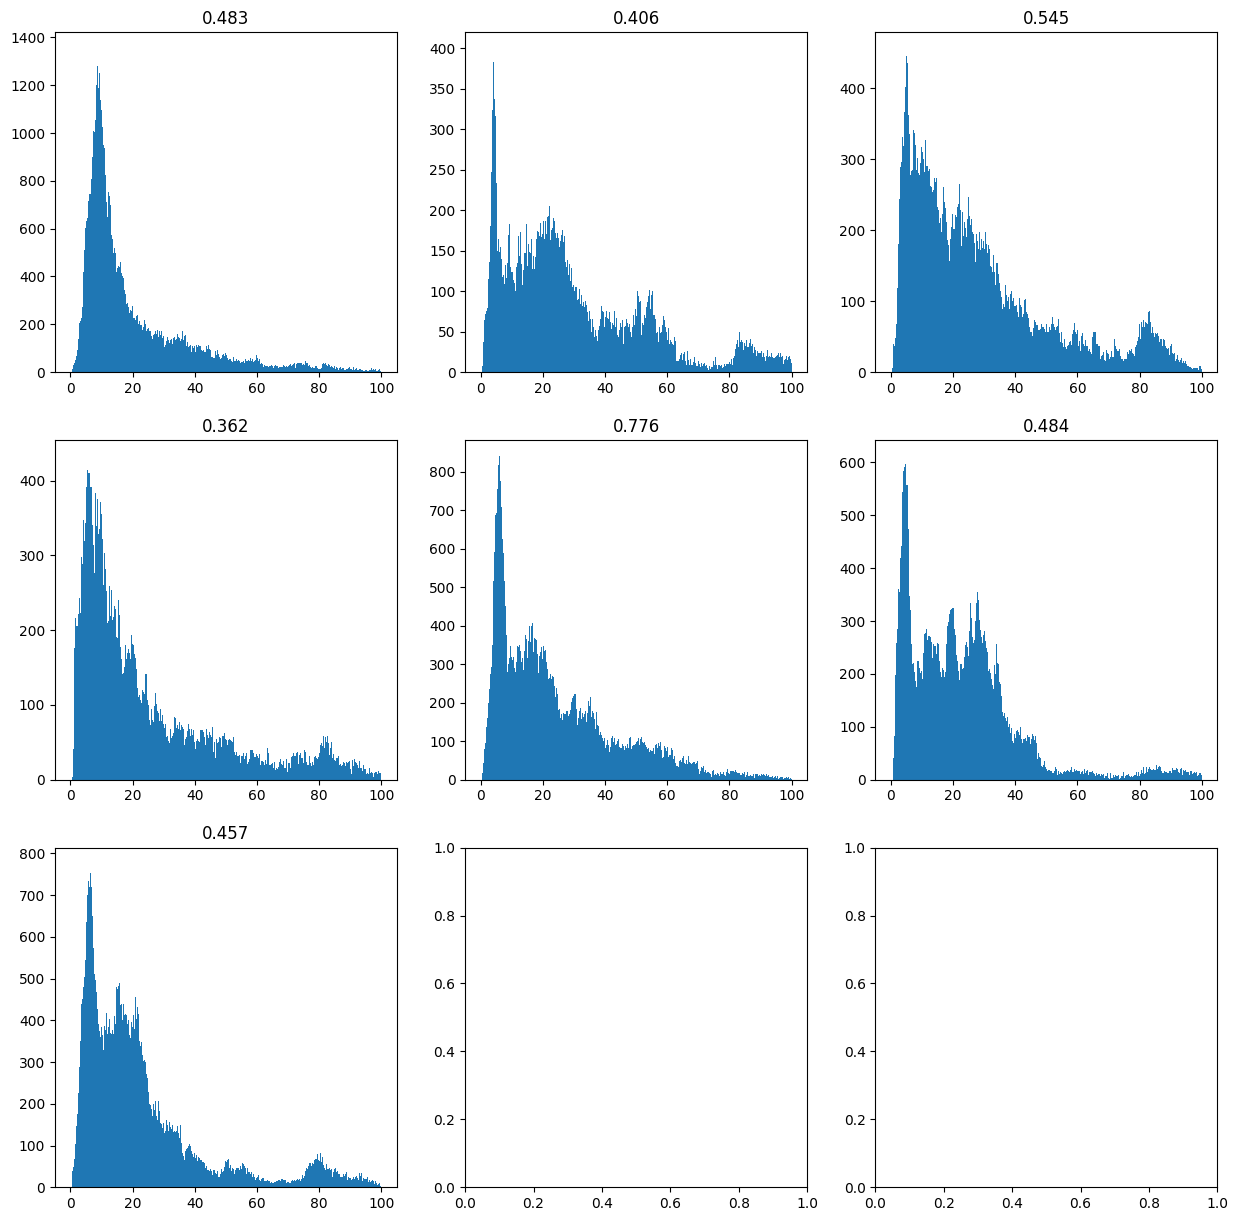

In [36]:
fig, ax = plt.subplots(3, 3, figsize=(15, 15))

for x,subID in zip(ax.ravel(), subID_list):
    r = rgas[subID]
    T = Tgas[subID]
    
    x.hist(r[T < 3E4], bins=np.linspace(0, 100, 1000));

    is_cold = T < 3E4
    is_out = r > 25
    is_coolio = np.logical_and(is_cold, is_out)
    is_warmio = np.logical_and(np.logical_not(is_cold), is_out)
    cold_mass = round(np.sum(snap_gas[subID]['Masses'][is_coolio]/header.HubbleParam), 3)
    warm_mass = round(np.sum(snap_gas[subID]['Masses'][is_warmio]/header.HubbleParam), 3)
    x.set_title(cold_mass)

    # print('cold fraction', cold_mass/(cold_mass+warm_mass)) 
    print('Z halo=', round(np.log10(Zhalo[subID]/0.0127), 3))
    print('Z disk=', round(np.log10(Zdisk[subID]/0.0127), 3))    

-7.49 5.111 -2.379
20.6968
-5.128 3.952 -1.176
11.339175
-9.702 6.315 -3.387
14.9079
-6.408 4.328 -2.079
18.313723
-4.444 2.401 -2.043
7.1187325
-5.941 3.107 -2.834
7.6572685
-4.786 3.001 -1.784
11.603601


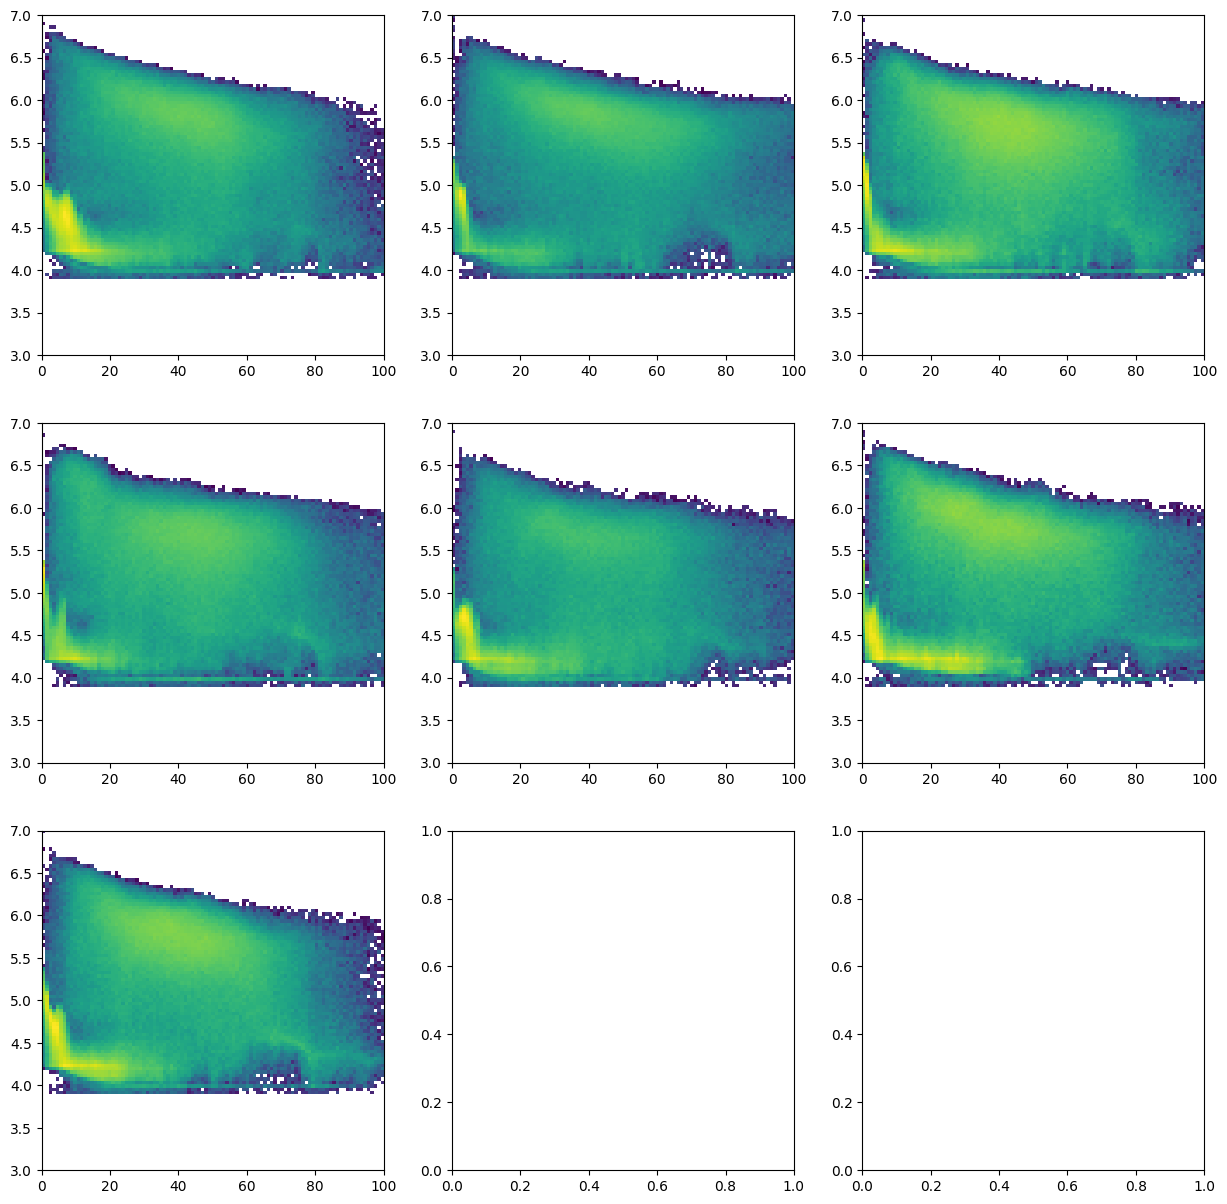

In [32]:
fig, ax = plt.subplots(3, 3, figsize=(15, 15))

for x,subID in zip(ax.ravel(), subID_list):
    r = rgas[subID]
    T = Tgas[subID]
    m = mgas[subID]
    
    rbins = np.linspace(0, 100, 100)
    Tbins = np.linspace(3, 7, 100)
    
    mbin, x_edge, y_edge, _ = binned_statistic_2d(r, np.log10(T), m, 
                                                     statistic='sum', bins=[rbins, Tbins])
    
    x.imshow(mbin.T, origin='lower', extent=[x_edge[0], x_edge[-1], y_edge[0], y_edge[-1]],
           norm=mpl.colors.LogNorm())
    
    x.set_aspect('auto')
    
    r0 = 40
    dr = 2
    
    pos = posgas[subID]
    vel = velgas[subID]
    mass = mgas[subID]
    
    r = np.linalg.norm(pos, axis=1)
    R = np.linalg.norm(pos[:,:2], axis=1)
    cphi = pos[:,0]/R
    sphi = pos[:,1]/R
    ctheta = pos[:,2]/r
    stheta = np.sqrt(1 - ctheta**2)
    
    vr = stheta * cphi * vel[:,0] + stheta * sphi * vel[:,1] + ctheta * vel[:,2]
    
    key = np.logical_and(r > r0-dr/2., r < r0+dr/2.)
    keyin = np.logical_and(key, vr < 0)
    keyout = np.logical_and(key, vr > 0)
    
    Mdotin = np.sum(mass[keyin] * vr[keyin])/dr
    Mdotout = np.sum(mass[keyout] * vr[keyout])/dr
    
    print(round(Mdotin, 3), round(Mdotout, 3), round(Mdotin+Mdotout, 3))
    print(np.sum(sfrgas[subID][r < 20]))
    
    # x.hist(r[T < 3E4], bins=np.linspace(0, 100, 1000));

    # is_cold = T < 3E4
    # is_out = r > 25
    # is_coolio = np.logical_and(is_cold, is_out)
    # is_warmio = np.logical_and(np.logical_not(is_cold), is_out)
    # cold_mass = round(np.sum(snap_gas[subID]['Masses'][is_coolio]/header.HubbleParam), 3)
    # warm_mass = round(np.sum(snap_gas[subID]['Masses'][is_warmio]/header.HubbleParam), 3)
    # x.set_title(cold_mass)

    # print('cold fraction', cold_mass/(cold_mass+warm_mass)) 
    # print('Z halo=', np.log10(Zhalo[subID]/0.0127))

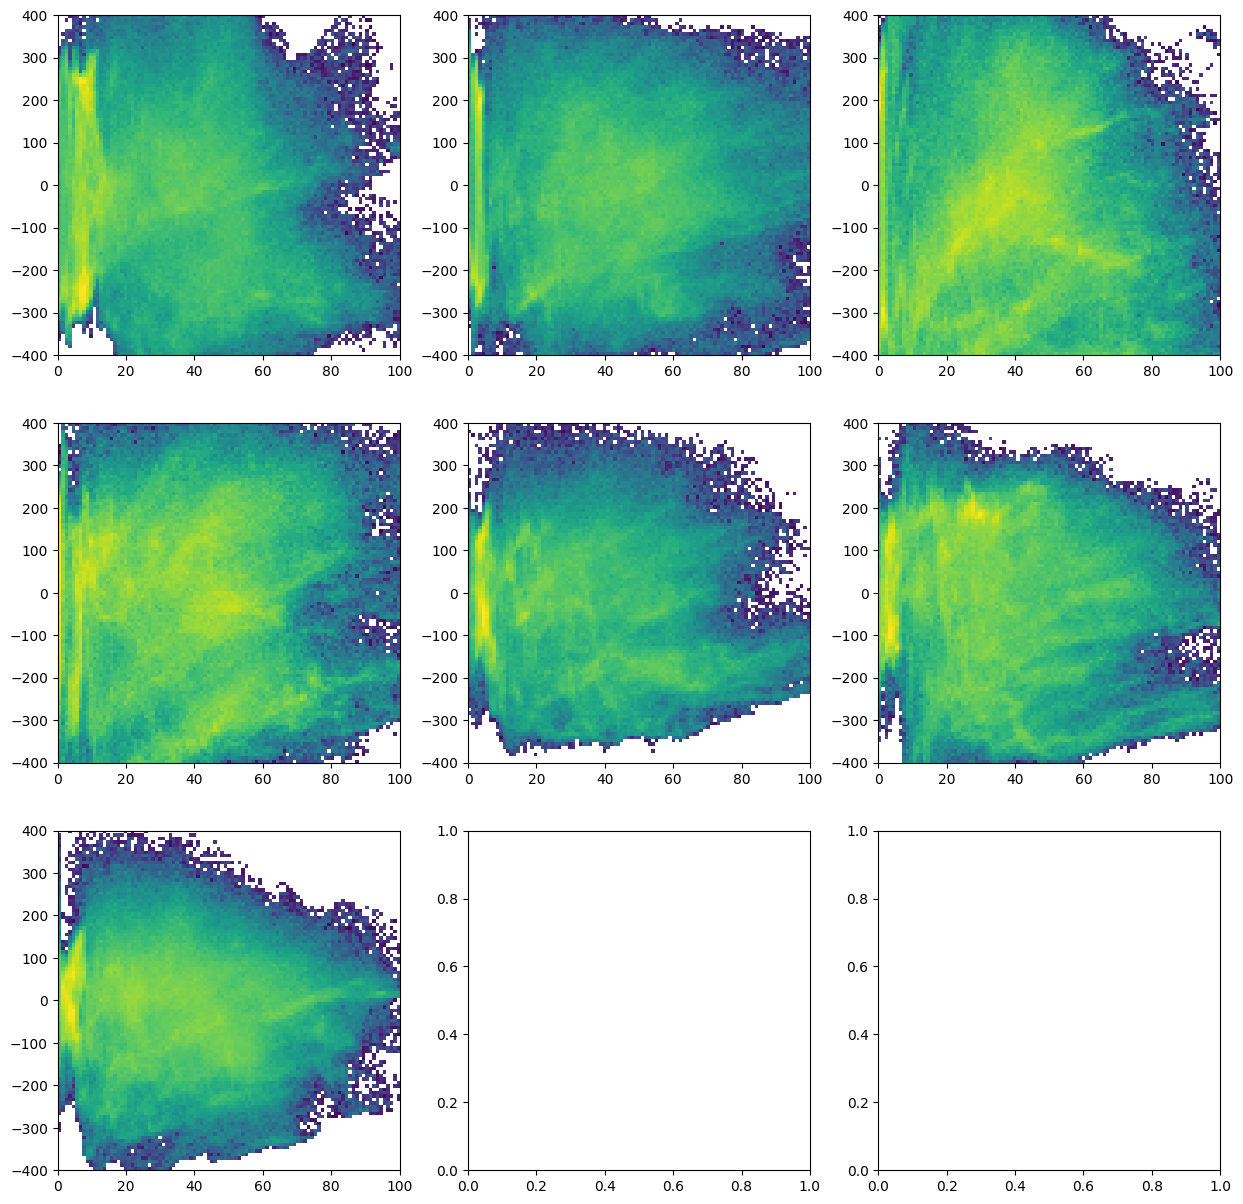

In [30]:
fig, ax = plt.subplots(3, 3, figsize=(15, 15))

for x,subID in zip(ax.ravel(), subID_list):
    r = rgas[subID]
    T = Tgas[subID]
    m = mgas[subID]
    
    pos = posgas[subID]
    vel = velgas[subID]
    mass = mgas[subID]
    
    r = np.linalg.norm(pos, axis=1)
    R = np.linalg.norm(pos[:,:2], axis=1)
    cphi = pos[:,0]/R
    sphi = pos[:,1]/R
    ctheta = pos[:,2]/r
    stheta = np.sqrt(1 - ctheta**2)
    
    vr = stheta * cphi * vel[:,0] + stheta * sphi * vel[:,1] + ctheta * vel[:,2]
    
    rbins = np.linspace(0, 100, 100)
    vrbins = np.linspace(-400, 400, 100)
    
    mbin, x_edge, y_edge, _ = binned_statistic_2d(r, vr, m, 
                                                     statistic='sum', bins=[rbins, vrbins])
    
    x.imshow(mbin.T, origin='lower', extent=[x_edge[0], x_edge[-1], y_edge[0], y_edge[-1]],
           norm=mpl.colors.LogNorm())
    
    x.set_aspect('auto')